In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
# OR: tf.keras.applications.resnet_v2.preprocess_input


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
channels = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, channels)

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/ahmedali/Downloads/Deep learning/Potato Disease Classification/PlantVillage",
    labels="inferred",
    label_mode="categorical",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch[0].numpy())

(32, 256, 256, 3)
[1. 0. 0.]


2026-02-19 23:35:29.993317: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


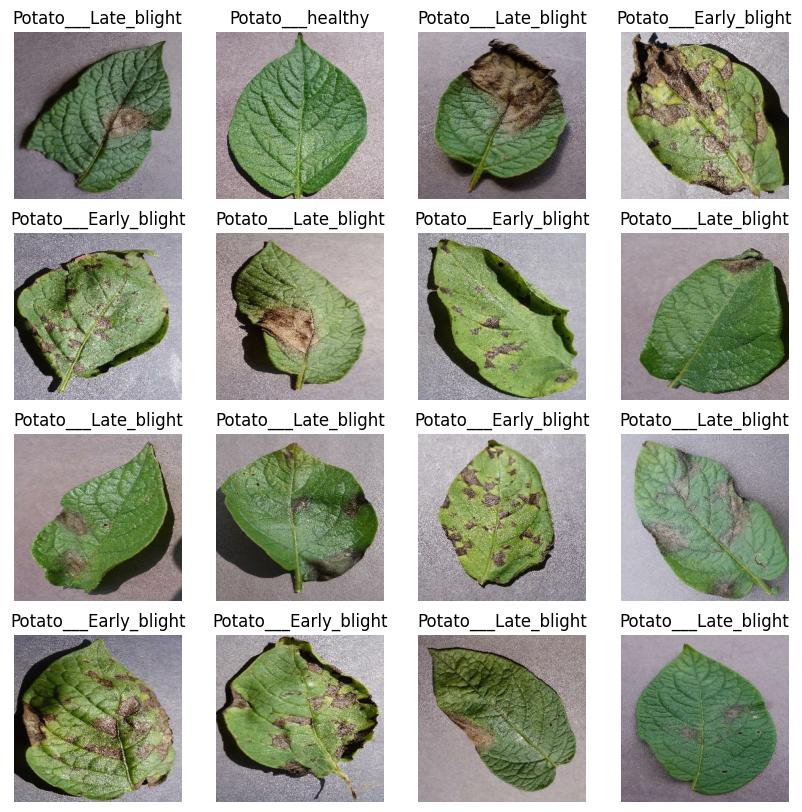

2026-02-19 23:35:31.024404: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        lab = labels[i]
        # If label is vector (one-hot or shape (1,)), reduce it to scalar
        if len(lab.shape) > 0:
            if lab.shape[-1] > 1:      # one-hot
                lab = tf.argmax(lab)
            else:                       # shape (1,)
                lab = tf.squeeze(lab)

        plt.title(class_names[int(lab.numpy())])
        plt.axis("off")
    plt.show()


In [8]:
train_size=0.8
train_ds=dataset.take(int(len(dataset)*train_size))
val_ds=dataset.skip(int(len(dataset)*train_size)).take(int(len(dataset)*0.1))
test_ds=dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
preprocessing=Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    layers.Rescaling(1./255, input_shape=input_shape),
])

/Users/ahmedali/Downloads/Deep learning/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
data_augmentation=Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

Building CNN Model

In [15]:
model=Sequential([
    preprocessing,
    data_augmentation,
    # 1st Conv layer
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    # 2nd Conv layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # 3rd Conv layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # 4th Conv layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # 5th Conv layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

/Users/ahmedali/Downloads/Deep learning/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,603 (1.62 MB)

 Trainable params: 425,603 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.4855 - loss: 0.9417 - val_accuracy: 0.5000 - val_loss: 0.8091
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.7014 - loss: 0.7036 - val_accuracy: 0.8073 - val_loss: 0.4578
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.8067 - loss: 0.5252 - val_accuracy: 0.7865 - val_loss: 0.5552
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.8466 - loss: 0.3833 - val_accuracy: 0.8802 - val_loss: 0.2694
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.8628 - loss: 0.3430 - val_accuracy: 0.8906 - val_loss: 0.2261
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.9034 - loss: 0.2445 - val_accuracy: 0.9323 - val_loss: 0.1823
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.9375 - loss: 0.1836 - val_accuracy: 0.9062 - val_loss: 0.2180
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step - accuracy: 0.9317 - loss: 0.1809 - val_accu

In [20]:
score = model.evaluate(test_ds)
print(f'Test Loss: {score[0]} / Test Accuracy: {score[1]}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9688 - loss: 0.0802
Test Loss: 0.08016850799322128 / Test Accuracy: 0.96875


In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

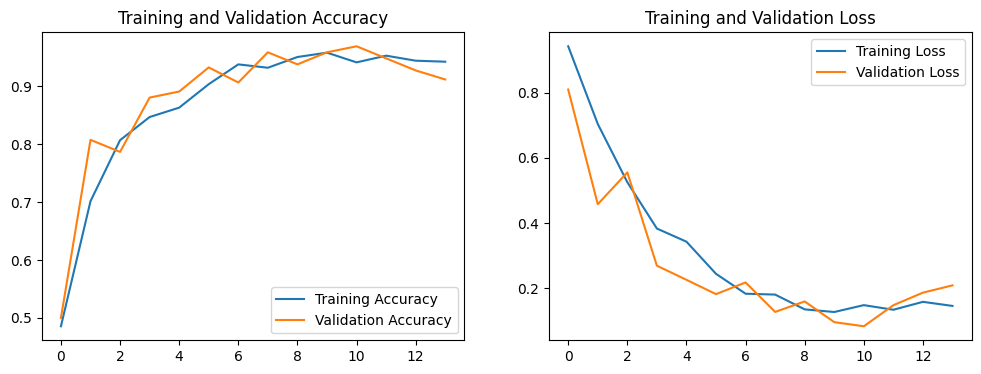

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

**EfficinetNetB2 Model**

In [23]:
eff_model=EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
    )
eff_model.trainable = False

model = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    data_augmentation,
    layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x)),
    eff_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,221,990 (16.11 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
elr=EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)

In [26]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[elr]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.8605 - loss: 0.3802 - val_accuracy: 0.9688 - val_loss: 0.1059
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9578 - loss: 0.1296 - val_accuracy: 0.9583 - val_loss: 0.1281
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9676 - loss: 0.0933 - val_accuracy: 0.9896 - val_loss: 0.0433
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.9809 - loss: 0.0541 - val_accuracy: 0.9948 - val_loss: 0.0309
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.9792 - loss: 0.0582 - val_accuracy: 0.9792 - val_loss: 0.0510
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9844 - loss: 0.0460 - val_accuracy: 0.9844 - val_loss: 0.0313
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9878 - loss: 0.0390 - val_accuracy: 0.9948 - val_loss: 0.0139
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9821 - loss: 0.0474 - val_accuracy:

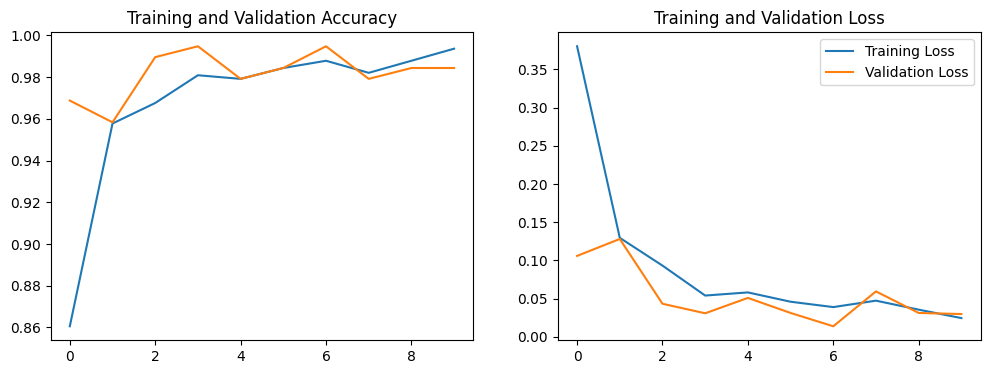

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label=['Araining Accuracy'])
plt.plot(history.history['val_accuracy'],label=['Validation Accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label=['Training Loss'])
plt.plot(history.history['val_loss'],label=['Validation Loss'])
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


**Resnet50V2 Model**

In [28]:
res_model=ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
res_model.trainable=False

model = Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE, input_shape=input_shape),
    data_augmentation,
    layers.Lambda(preprocess_input),
    res_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,835,523 (90.93 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [30]:
elr=EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[elr]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 489ms/step - accuracy: 0.7558 - loss: 0.5688 - val_accuracy: 0.8958 - val_loss: 0.2138
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.9086 - loss: 0.2591 - val_accuracy: 0.9427 - val_loss: 0.1124
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.9392 - loss: 0.1881 - val_accuracy: 0.9688 - val_loss: 0.0698
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.9502 - loss: 0.1367 - val_accuracy: 0.9792 - val_loss: 0.0573
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 486ms/step - accuracy: 0.9589 - loss: 0.1280 - val_accuracy: 0.9792 - val_loss: 0.0680
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.9583 - loss: 0.1193 - val_accuracy: 0.9896 - val_loss: 0.0473
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 491ms/step - accuracy: 0.9659 - loss: 0.0956 - val_accuracy: 0.9792 - val_loss: 0.0528
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 485ms/step - accuracy: 0.9705 - loss: 0.0870 - val_accu

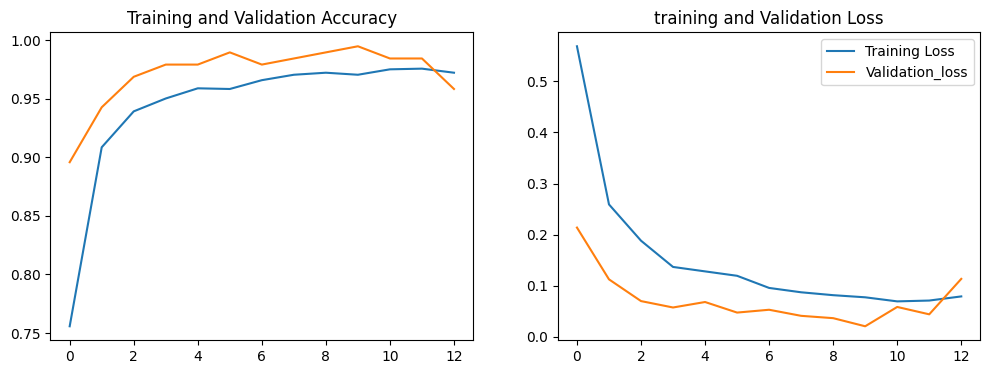

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label=['Training Accuracy'])
plt.plot(history.history['val_accuracy'], label=['Validation Accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label=['Training Loss'])
plt.plot(history.history['val_loss'],label=['Validation_loss'])
plt.title('training and Validation Loss')
plt.legend()
plt.show()

In [33]:
mobile=MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
mobile.trainable=False

model=Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE, input_shape=input_shape),
    data_augmentation,
    layers.Lambda(preprocess_input),
    mobile,
    GlobalAveragePooling2D(),
    Dense(128,activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')

])
model.summary()

/var/folders/m1/xvtky8_d4sd596s41ptzq2wh0000gn/T/ipykernel_25167/694506907.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile=MobileNetV2(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

elr=EarlyStopping(monitor='val_loss',
                  patience=3,
                  restore_best_weights=True
                  
                  )

In [35]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[elr]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8339 - loss: 0.4248 - val_accuracy: 0.9531 - val_loss: 0.1446
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9520 - loss: 0.1472 - val_accuracy: 0.9688 - val_loss: 0.1030
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9572 - loss: 0.1305 - val_accuracy: 0.9427 - val_loss: 0.1448
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9716 - loss: 0.0841 - val_accuracy: 0.9583 - val_loss: 0.1236
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9722 - loss: 0.0740 - val_accuracy: 0.9792 - val_loss: 0.0692
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9797 - loss: 0.0519 - val_accuracy: 0.9740 - val_loss: 0.0672
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9809 - loss: 0.0666 - val_accuracy: 0.9635 - val_loss: 0.1010
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9745 - loss: 0.0636 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted label: Potato___Late_blight


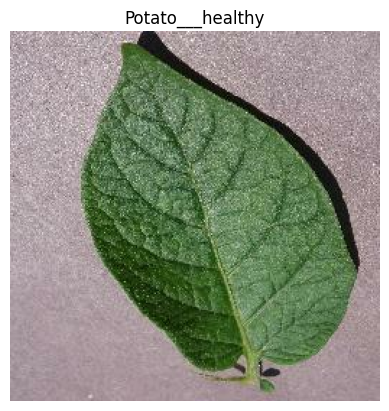

In [36]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    plt.title(class_names[int(tf.argmax(first_label).numpy())])
    
    prediction =model.predict(image_batch)
    print(f'Predicted label: {class_names[int(tf.argmax(prediction[5]).numpy())]}')
    plt.axis("off")
    plt.show()

In [37]:
def predict_image(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    predicted_class = class_names[int(tf.argmax(predictions[0]).numpy())]
    confidence=round(tf.reduce_max(predictions[0]).numpy() * 100, 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2026-02-19 23:53:10.276358: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


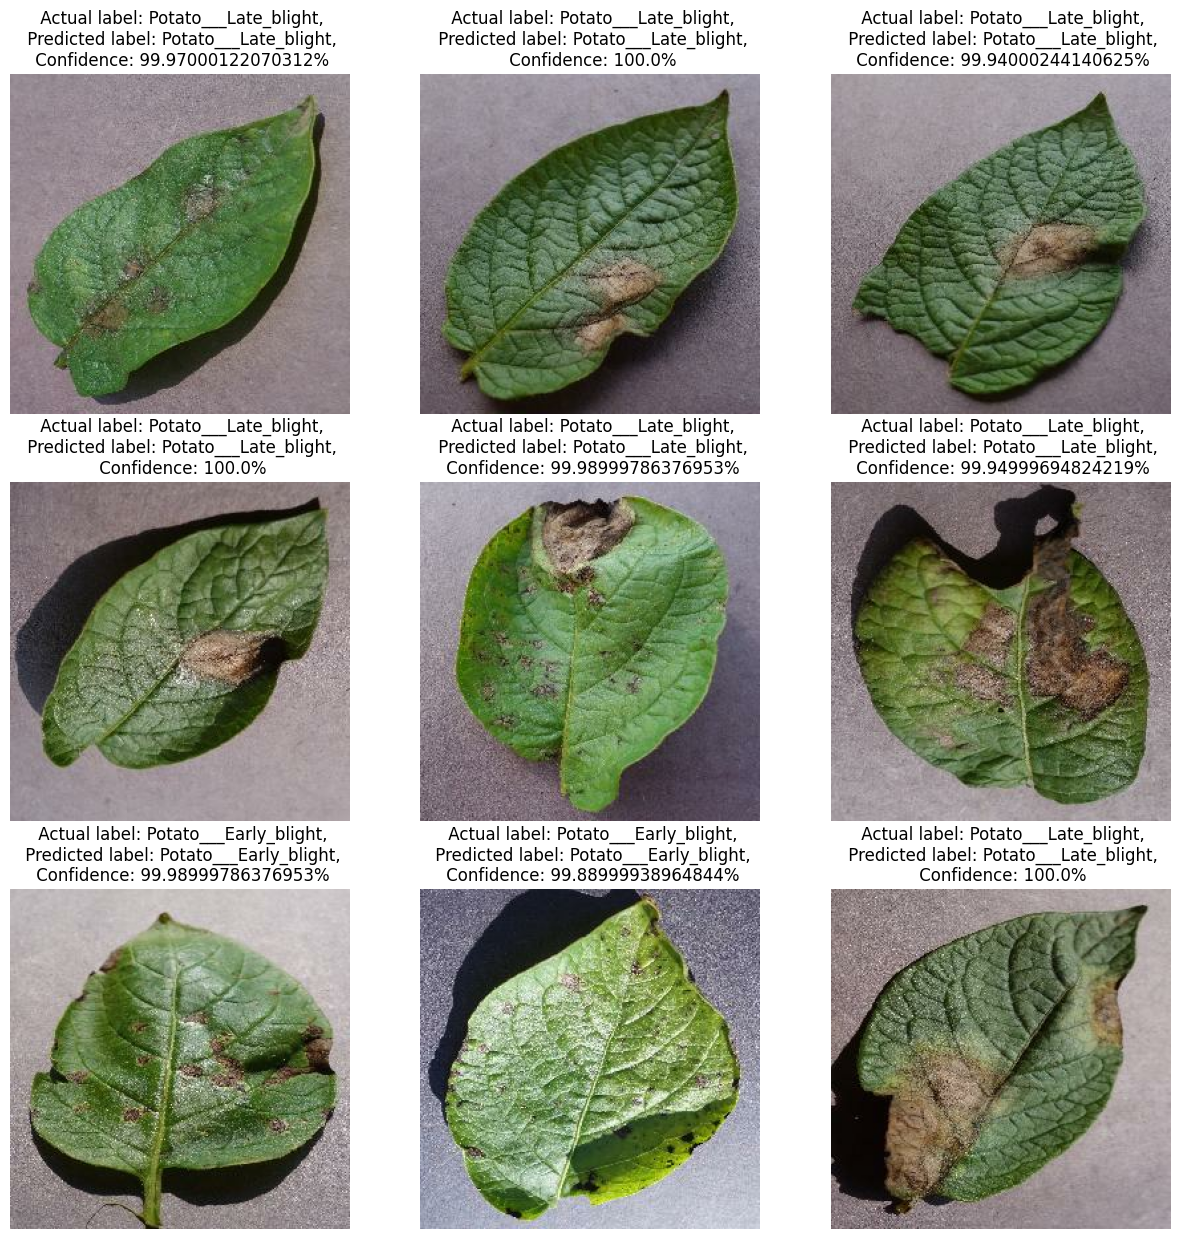

In [38]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class= class_names[int(tf.argmax(labels[i]).numpy())]
        plt.title(f' Actual label: {actual_class},\n Predicted label: {predicted_class},\n Confidence: {confidence}%')
        plt.axis("off")

In [40]:
import os, json
os.makedirs("deploy", exist_ok=True)

model.save("deploy/potato_model.h5")

with open("deploy/class_names.json", "w") as f:
    json.dump(class_names, f)